# Starbucks Capstone Challenge

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.


### Problem Statement

We are trying to discover a way to predict what is the best type of offers for each custommer

# Metrics

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Analysis 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [175]:

from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization
import visuals as vs


In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data preprocessing 

### portfolio wrangling and cleaning

In [12]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [13]:
portfolio.shape

(10, 6)

In [14]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [103]:
new_editted_portfolio = portfolio.copy()

In [104]:
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
new_editted_portfolio = pd.concat([new_editted_portfolio, dummy], axis=1)
new_editted_portfolio.drop(columns='channels',inplace = True)

In [131]:
dummy = pd.get_dummies(portfolio.offer_type	.apply(pd.Series).stack()).sum(level=0)
new_editted_portfolio = pd.concat([new_editted_portfolio, dummy], axis=1)

In [132]:
new_editted_portfolio.rename(columns={'id':'offer_id'},inplace = True)


In [133]:
new_editted_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### profile wrangling and cleaning

In [107]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [108]:
profile.shape

(17000, 5)

In [109]:
new_editted_profile = profile.copy()

In [110]:
new_editted_profile['became_member_on'] = pd.to_datetime(new_editted_profile['became_member_on'], format='%Y%m%d').dt.date

In [111]:
new_editted_profile.rename(columns={'id':'customer_id'},inplace= True)


In [112]:
new_editted_profile['memberdays']= (datetime.datetime.today().date()-new_editted_profile['became_member_on']).dt.days

In [113]:
new_editted_profile['age']=new_editted_profile['age'].apply(lambda x: np.nan if x==118 else x)

In [114]:
new_editted_profile['gender'].fillna('Na', inplace=True)


In [115]:
new_editted_profile['age_groups'] = pd.cut(new_editted_profile.age, bins=[0, 12, 18, 21, 64, 100], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

In [116]:
new_editted_profile['income'].fillna((new_editted_profile['income'].mean()), inplace=True)


In [117]:
new_editted_profile.head()

,gender,age,customer_id,became_member_on,income,memberdays,age_groups
0,Na,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,1496,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,1343,adult
2,Na,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,981,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,1410,elderly
4,Na,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,1323,NaN


### Transcript wrangling and cleaning


In [33]:
transcript.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [34]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [35]:
transcript.iterrows()

<generator object DataFrame.iterrows at 0x7fdab72de890>

In [36]:
transcript.shape


(306534, 4)

In [37]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [38]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [84]:
new_editted_transcript = transcript.copy()

In [85]:
new_editted_transcript.rename(columns={'person':'customer_id'},inplace = True)


In [86]:
new_editted_transcript['event'] = new_editted_transcript['event'].str.replace(' ', '-')


In [87]:
new_editted_transcript

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [88]:
dummy = pd.get_dummies(transcript.event.apply(pd.Series).stack()).sum(level=0)

In [89]:
new_editted_transcript = pd.concat([new_editted_transcript, dummy], axis=1 )


In [90]:
new_editted_transcript = new_editted_transcript[new_editted_transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
new_editted_transcript['offer_id'] = new_editted_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

In [91]:
new_editted_transcript.offer_id.isnull().sum()

0

In [92]:
new_editted_transcript = new_editted_transcript.drop('value', axis=1)


In [93]:
new_editted_transcript.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [134]:
first_merge = pd.merge(new_editted_transcript, new_editted_profile, on='customer_id')


In [135]:
first_merge.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,gender,age,became_member_on,income,memberdays,age_groups
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1410,elderly
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1410,elderly
2,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017-05-09,100000.0,1410,elderly
3,78afa995795e4d85b5d9ceeca43f5fef,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,2017-05-09,100000.0,1410,elderly
4,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,216,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,2017-05-09,100000.0,1410,elderly


In [136]:
full_list = pd.merge(first_merge, new_editted_portfolio, on='offer_id', how='left')


In [137]:
full_list.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,gender,age,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,216,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1


In [138]:
full_list.shape

(167581, 25)

In [139]:
full_list.dropna(subset=['offer_id'],inplace=True)

In [140]:
full_list.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,gender,age,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,216,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1


In [141]:
full_list.shape

(167581, 25)

# Data Exploration and Data Visualization :


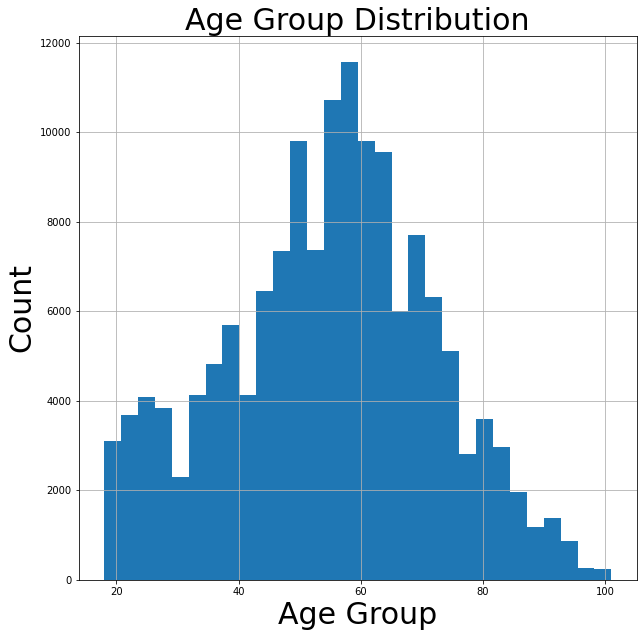

In [142]:
plt.figure(figsize=(10,10))
full_list.age.hist(bins = 30)
plt.xlabel('Age Group',size=30)
plt.ylabel('Count',size=30)
plt.title('Age Group Distribution',size=30);

- most of our data set are with the range between 52 to 60 years

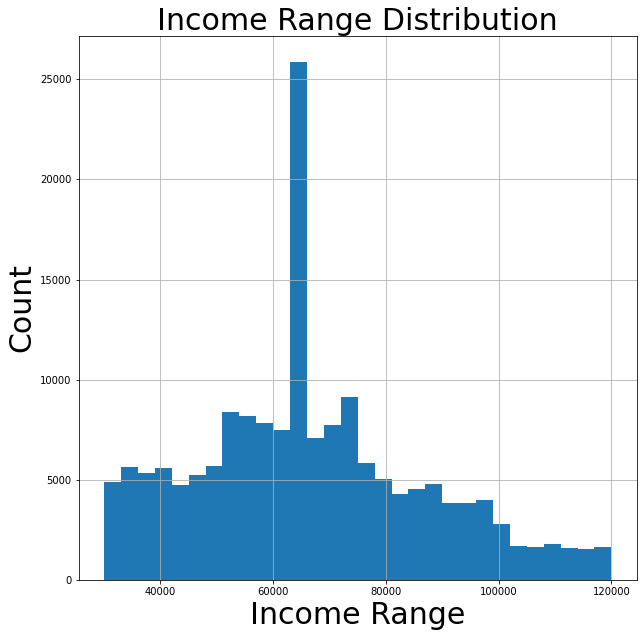

In [143]:
plt.figure(figsize=(10,10))
full_list.income.hist(bins = 30);
plt.xlabel('Income Range',size=30)
plt.ylabel('Count',size=30)
plt.title('Income Range Distribution',size=30);

- average income user is between 65k to 70k

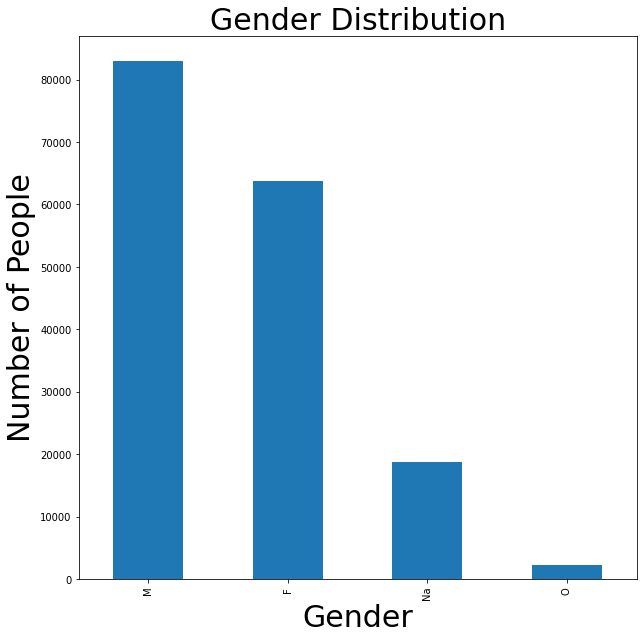

In [144]:
plt.figure(figsize=(10,10))
ax = full_list.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People',size=30)
plt.xlabel('Gender',size=30)
plt.title('Gender Distribution',size=30);

- Males are more than the females by about 20000

In [145]:
full_list.rename(columns={'offer received':'offer_received'},inplace = True)
full_list.rename(columns={'offer viewed':'offer_viewed'},inplace = True)
full_list.rename(columns={'offer completed':'offer_completed'},inplace = True)


Text(0, 0.5, 'Offer Status')

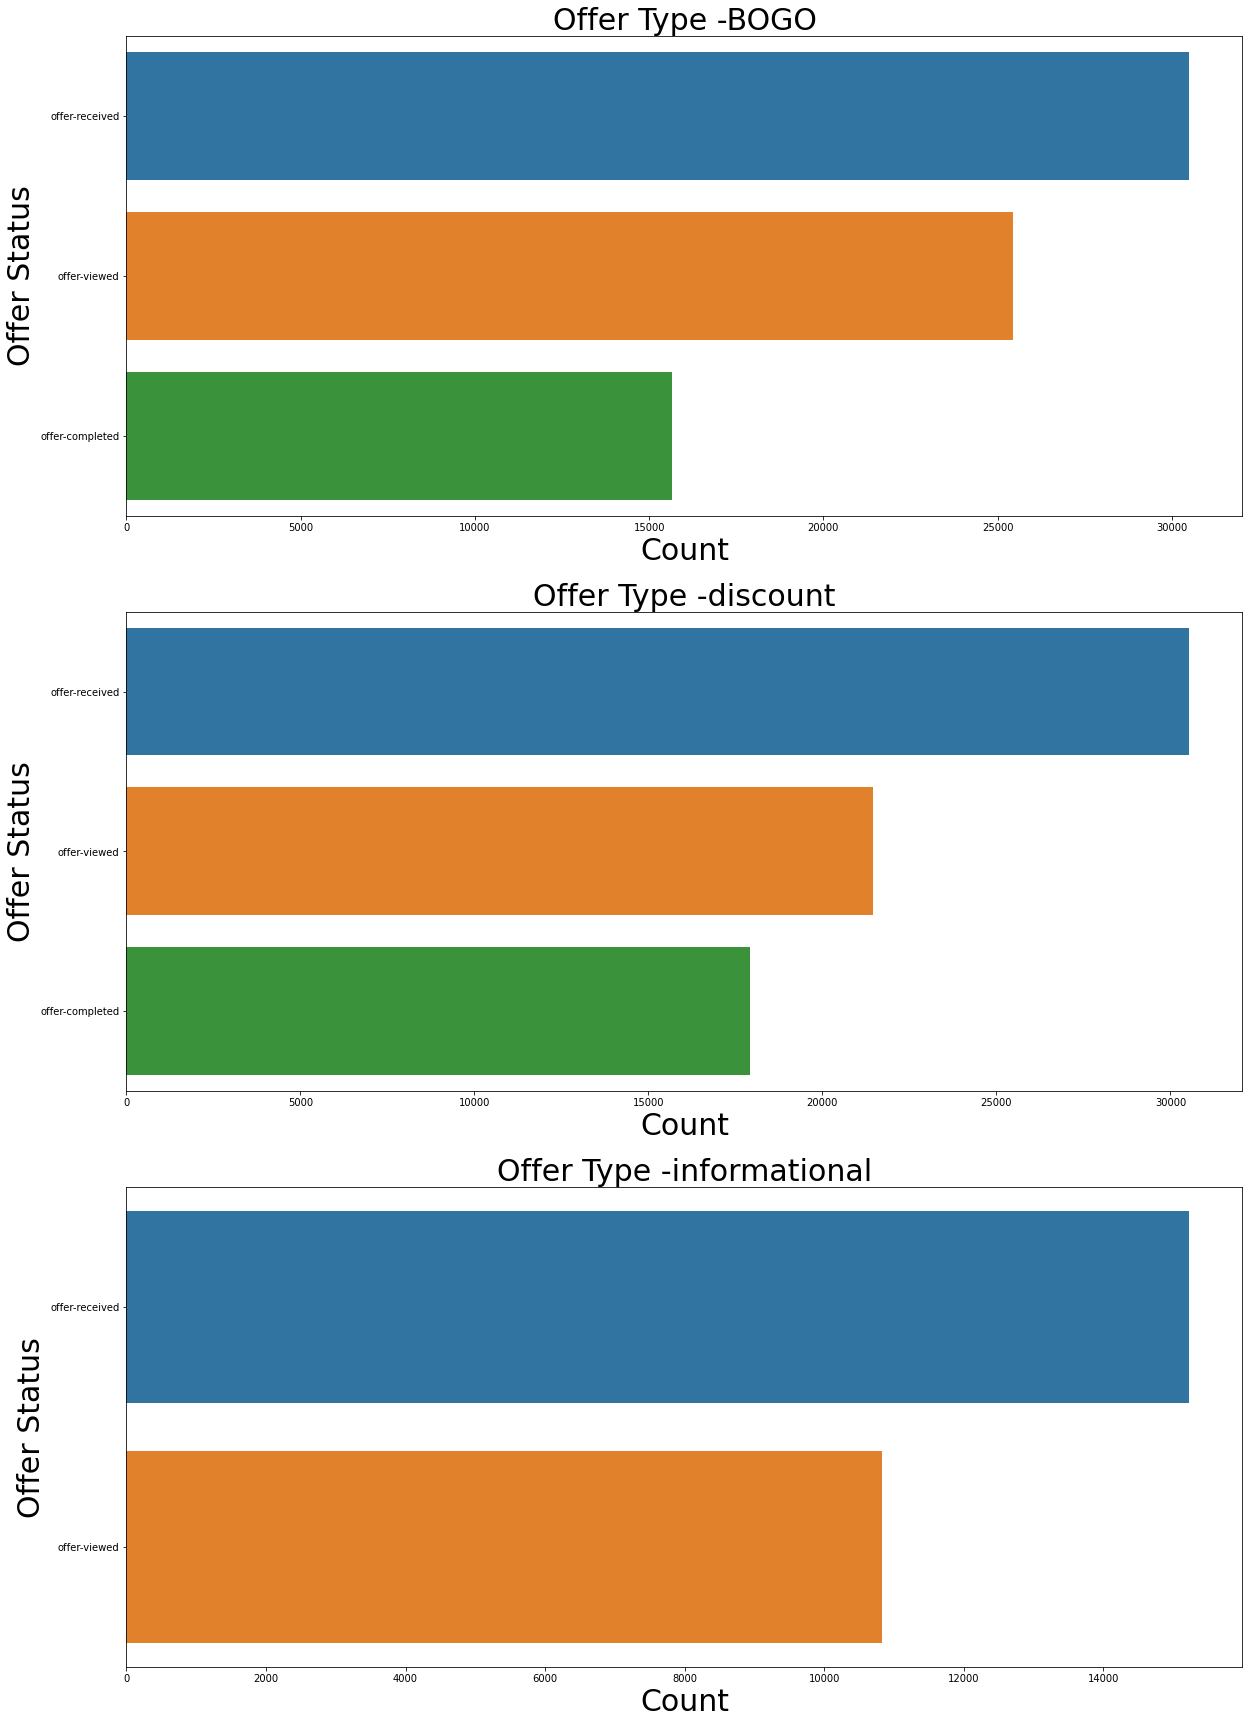

In [146]:
fig, ax =plt.subplots(3,1,figsize=(20,30))
sns.countplot(y=full_list[full_list.bogo == 1].event,ax=ax[0]);
ax[0].set_title('Offer Type -BOGO',fontsize=30)
ax[0].set_xlabel('Count',fontsize=30)
ax[0].set_ylabel('Offer Status',size=30)
sns.countplot(y=full_list[full_list.discount == 1].event,ax=ax[1]);
ax[1].set_title('Offer Type -discount',fontsize=30)
ax[1].set_xlabel('Count',fontsize=30)
ax[1].set_ylabel('Offer Status',size=30)
sns.countplot(y=full_list[full_list.informational == 1].event,ax=ax[2]);
ax[2].set_title('Offer Type -informational',fontsize=30)
ax[2].set_xlabel('Count',fontsize=30)
ax[2].set_ylabel('Offer Status',size=30)

Text(0, 0.5, 'Offer ID')

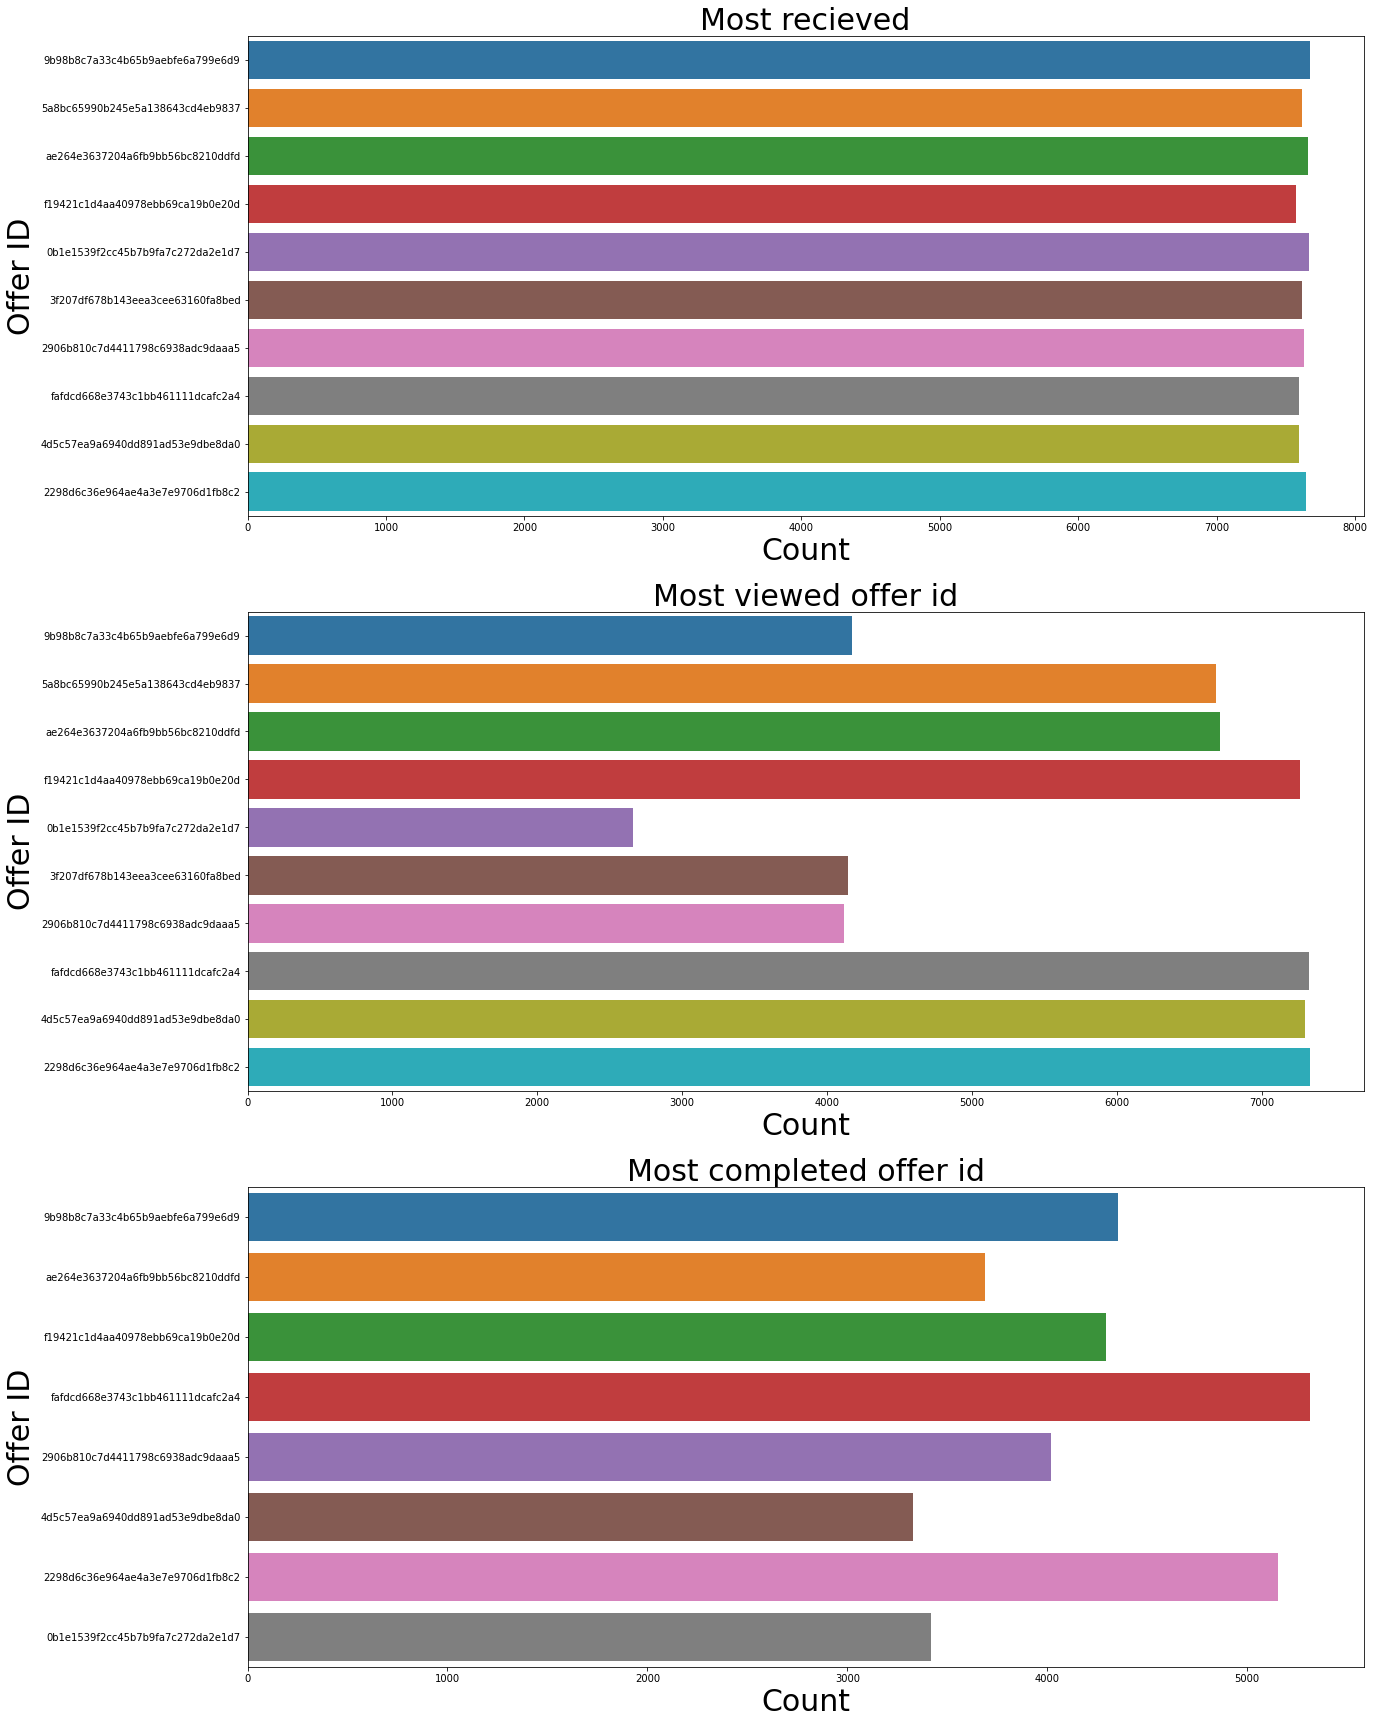

In [147]:
fig, ax =plt.subplots(3,1,figsize=(20,30))
sns.countplot(y=full_list[full_list.event == 'offer-received'].offer_id,ax=ax[0]);
ax[0].set_title('Most recieved',fontsize=30)
ax[0].set_xlabel('Count',fontsize=30)
ax[0].set_ylabel('Offer ID',size=30)
sns.countplot(y=full_list[full_list.event == 'offer-viewed'].offer_id,ax=ax[1]);
ax[1].set_title('Most viewed offer id',fontsize=30)
ax[1].set_xlabel('Count',fontsize=30)
ax[1].set_ylabel('Offer ID',size=30)
sns.countplot(y=full_list[full_list.event == 'offer-completed'].offer_id,ax=ax[2]);
ax[2].set_title('Most completed offer id',fontsize=30)
ax[2].set_xlabel('Count',fontsize=30)
ax[2].set_ylabel('Offer ID',size=30)

- offer completed ratio is not small  

/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


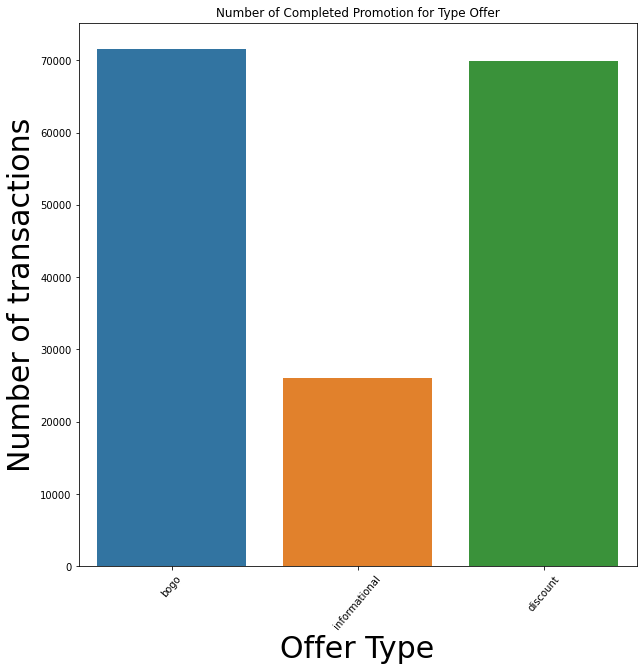

In [148]:
plt.figure(figsize=(10,10))
sns.countplot(full_list[~full_list['offer_type'].isnull()]['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions',fontsize=30)
plt.xlabel('Offer Type',fontsize=30)
plt.xticks(rotation = 50)
plt.show();

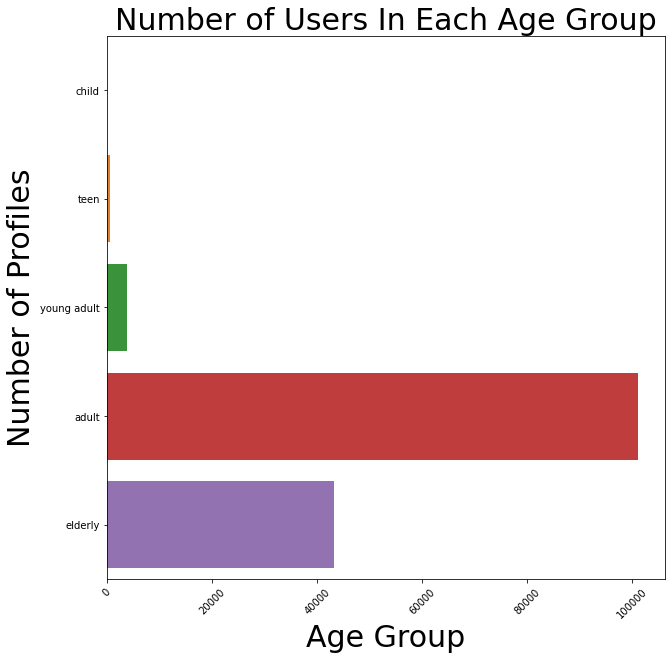

In [149]:
plt.figure(figsize=(10,10))
sns.countplot(y=full_list['age_groups'])
plt.title('Number of Users In Each Age Group',fontsize=30)
plt.ylabel('Number of Profiles',fontsize=30)
plt.xlabel('Age Group',fontsize=30)
plt.xticks(rotation = 45)
plt.show();

Bogo and Discount seem the most and they are close to each other with bogo been slightly higher



### Model preparation 

In [178]:
df2 = pd.DataFrame(full_list)

In [179]:
df2.head()

,customer_id,event,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,gender,age,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,...,5,7,bogo,1,1,0,1,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer-received,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,216,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,F,75.0,...,0,3,informational,1,1,1,0,0,0,1


In [180]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   customer_id       167581 non-null  object  
 1   event             167581 non-null  object  
 2   time              167581 non-null  int64   
 3   offer_completed   167581 non-null  uint8   
 4   offer_received    167581 non-null  uint8   
 5   offer_viewed      167581 non-null  uint8   
 6   transaction       167581 non-null  uint8   
 7   offer_id          167581 non-null  object  
 8   gender            167581 non-null  object  
 9   age               148805 non-null  float64 
 10  became_member_on  167581 non-null  object  
 11  income            167581 non-null  float64 
 12  memberdays        167581 non-null  int64   
 13  age_groups        148754 non-null  category
 14  reward            167581 non-null  int64   
 15  difficulty        167581 non-null  int64   
 16  du

In [181]:
df2.drop(["event","time","memberdays",'became_member_on',"bogo","discount","informational"],axis=1,inplace=True)

In [182]:
df2.dropna(inplace=True)

In [183]:
labels_gender = df2['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
df2.replace(replace_map_comp_gender, inplace=True)


In [184]:
labels_age_group = df2['age_groups'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_groups' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
df2.replace(replace_map_comp_age_group, inplace=True)

In [191]:
df2.drop(df2[df2.offer_type=="informational"].index,inplace=True)


In [207]:
labels_offer_type = df2['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(0,2)))}}
df2.replace(replace_map_comp_offer_type, inplace=True)

In [208]:
df2.head()

,customer_id,offer_completed,offer_received,offer_viewed,transaction,offer_id,gender,age,income,age_groups,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,75.0,100000.0,5,5,5,7,0,1,1,0,1
1,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,75.0,100000.0,5,5,5,7,0,1,1,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,75.0,100000.0,5,5,5,7,0,1,1,0,1
5,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd,1,75.0,100000.0,5,10,10,7,0,1,1,1,0
6,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,1,75.0,100000.0,5,10,10,7,0,1,1,1,0


In [209]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126106 entries, 0 to 167580
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      126106 non-null  object 
 1   offer_completed  126106 non-null  uint8  
 2   offer_received   126106 non-null  uint8  
 3   offer_viewed     126106 non-null  uint8  
 4   transaction      126106 non-null  uint8  
 5   offer_id         126106 non-null  object 
 6   gender           126106 non-null  int64  
 7   age              126106 non-null  float64
 8   income           126106 non-null  float64
 9   age_groups       126106 non-null  int64  
 10  reward           126106 non-null  int64  
 11  difficulty       126106 non-null  int64  
 12  duration         126106 non-null  int64  
 13  offer_type       126106 non-null  int64  
 14  email            126106 non-null  uint8  
 15  mobile           126106 non-null  uint8  
 16  social           126106 non-null  uint

In [210]:
Y = df2['offer_type']
X =df2.drop(['offer_type','customer_id','offer_id'],axis=1)

In [211]:
X

,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,age_groups,reward,difficulty,duration,email,mobile,social,web
0,0,1,0,0,1,75.0,100000.0,5,5,5,7,1,1,0,1
1,0,0,1,0,1,75.0,100000.0,5,5,5,7,1,1,0,1
2,1,0,0,0,1,75.0,100000.0,5,5,5,7,1,1,0,1
5,0,1,0,0,1,75.0,100000.0,5,10,10,7,1,1,1,0
6,0,0,1,0,1,75.0,100000.0,5,10,10,7,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,0,0,1,0,1,52.0,86000.0,4,3,7,7,1,1,1,1
167577,1,0,0,0,1,52.0,86000.0,4,3,7,7,1,1,1,1
167578,0,1,0,0,2,20.0,70000.0,3,3,7,7,1,1,1,1
167579,0,0,1,0,2,20.0,70000.0,3,3,7,7,1,1,1,1


In [212]:
Y.to_list()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,


### Model preparation and evaluation and validation

In [197]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler


In [213]:

To_scale = MinMaxScaler()
to_normalize = ['age','reward','age_groups','duration' , 'income']

X[to_normalize] = To_scale.fit_transform(X[to_normalize])
X.head()

,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,age_groups,reward,difficulty,duration,email,mobile,social,web
0,0,1,0,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
1,0,0,1,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
2,1,0,0,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
5,0,1,0,0,1,0.695122,0.777778,1.0,1.000,10,0.4,1,1,1,0
6,0,0,1,0,1,0.695122,0.777778,1.0,1.000,10,0.4,1,1,1,0


In [214]:
X.head()

,offer_completed,offer_received,offer_viewed,transaction,gender,age,income,age_groups,reward,difficulty,duration,email,mobile,social,web
0,0,1,0,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
1,0,0,1,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
2,1,0,0,0,1,0.695122,0.777778,1.0,0.375,5,0.4,1,1,0,1
5,0,1,0,0,1,0.695122,0.777778,1.0,1.000,10,0.4,1,1,1,0
6,0,0,1,0,1,0.695122,0.777778,1.0,1.000,10,0.4,1,1,1,0


In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 100884 samples.
Testing set has 25222 samples.


In [219]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(Y)
FP =Y.shape[0]-TP
TN =0
FN =0
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
beta = 0.5

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore =  (1+ beta**2) * (precision * recall) / ((beta ** 2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4939, F-score: 0.5495]


In [216]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] =  accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta = 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

SVC trained on 1008 samples.
SVC trained on 10088 samples.
SVC trained on 100884 samples.
RandomForestClassifier trained on 1008 samples.
RandomForestClassifier trained on 10088 samples.
RandomForestClassifier trained on 100884 samples.
AdaBoostClassifier trained on 1008 samples.
AdaBoostClassifier trained on 10088 samples.
AdaBoostClassifier trained on 100884 samples.


/home/mostafahaggag/udacity_data_science_course/unit_4_data_engineering/lesson_5_project/Udacity_data_science_nano_degree_projects/Capestone/Starbucks/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


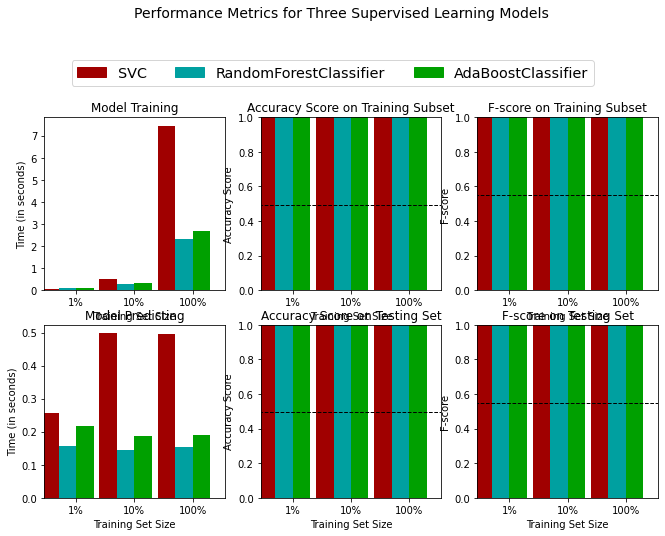

In [220]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = svm.SVC(random_state = 7)
clf_B = RandomForestClassifier(random_state=543)
clf_C = AdaBoostClassifier(random_state=543)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 =  int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Justification
we are trying to calculate the accuracy for dataset using 3 different models.
We are able to see that the 3 models are able to reach 100% accuracy but the random forest classifier is able of running is lesss time
I choose to work with ada boost classifier

In [221]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=543)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = dict(n_estimators=[250,750,1000],
                learning_rate=[1,0.01,0.001],
                algorithm =['SAMME', 'SAMME.R'])
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 1.0000
F-score on testing data: 1.0000

Optimized Model
------
Final accuracy score on the testing data: 1.0000
Final F-score on the testing data: 1.0000


### Improvement
we try to check if there are some specific improvement that can be done on the model by optimizing the model. however the current parameter is able of reaching 100% accuracy

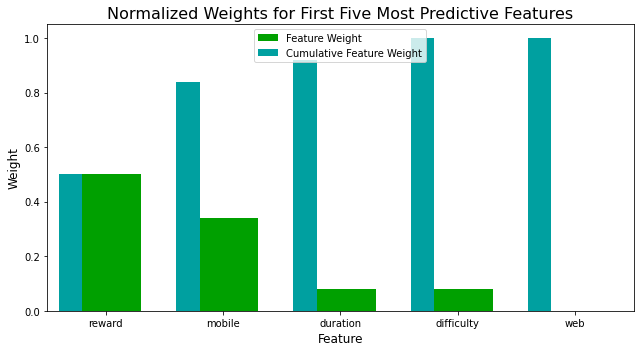

In [222]:
classification = AdaBoostClassifier(random_state=543)

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = classification.fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = classification.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [223]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 1.0000
F-score on testing data: 1.0000

Final Model trained on reduced data
------
Accuracy on testing data: 1.0000
F-score on testing data: 1.0000


### Conclusion

We are able to predict perfectly which is the best offer for each custommer according to different data collected by the user